# README

* Tuning the network parameters

In [1]:
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
original_features=['scalar.fx', 'scalar.fy', 'scalar.fz','scalar.tx', 'scalar.ty','scalar.tz','scalar.current','scalar.ang_vel']

# Load data

In [3]:
%%time
dfs = [pd.read_csv(filename, sep=',',header=0) for filename in glob.glob("data/*.csv")]

CPU times: user 13.5 s, sys: 676 ms, total: 14.2 s
Wall time: 14.2 s


## Get the longest and shortest sequences

In [4]:
longest_len = max(dfs, key=lambda df: df.shape[0]).shape[0]
shortest_len = min(dfs, key=lambda df: df.shape[0]).shape[0]
print("shortest_len={}, longest_len={}".format( shortest_len, longest_len) )

shortest_len=535, longest_len=4479


# Create windows

* Windows are equal length comprising of N, eg. 32, time frames.
* A wavelet is obtained by using a moving window of length N.
* The beginning of the moving window starts M, e.g. 8, time frames behind the beginning of the previous window.

In [5]:
def rolling(df, original_features=original_features, 
            frames=32, steps=8, type_class='class.type', stage_class='class.stage'):
    """
    df - dataframe
    """
    starts = np.arange(0, len(df)-frames, steps)[:-1] # an array of start locations    
    x = np.zeros((len(starts), frames, len(original_features)))
    y = np.zeros((len(starts), 1))
    y2 = np.zeros((len(starts), 1))
    
    for i in np.arange(len(starts)):
        start = starts[i]
        x[i] = df.iloc[start:start+frames].as_matrix(columns=original_features)
        y[i] = df[type_class].iloc[start + steps]
        y2[i] = df[stage_class].iloc[start + steps]

    return x, y, y2

In [6]:
def moving_windows(dfs, frames=32, steps=8):
    """split each observation to a tuple of X, Y, Y2 using a moving window"""

    X=None; Y=None; Y2=None
    for df in dfs:
        x, y, y2 = rolling(df, original_features,frames, steps)
        if X is None:
            X = x.copy(); Y = y.copy(); Y2 = y2.copy();
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
            Y2= np.append(Y2, y2, axis=0)
    return X, Y, Y2

## save or load window-based data

In [3]:
%%time
frames = 32
steps = 8

import os.path
file_path = 'data_win/f32s8.npz'
if os.path.exists(file_path):
    loaded = np.load(file_path)
    X = loaded['X']
    Y = loaded['Y']
    Y2 = loaded['Y2']
else:
    X, Y, Y2 = moving_windows(dfs, frames, steps)
    np.savez_compressed(file_path, X=X, Y=Y, Y2=Y2)

CPU times: user 4.2 s, sys: 243 ms, total: 4.44 s
Wall time: 4.44 s


#### Plot a histogram of types

(array([      0.,  433720.,   82458.,   21594.,    3516.,    2264.,
           6397.,    3243.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

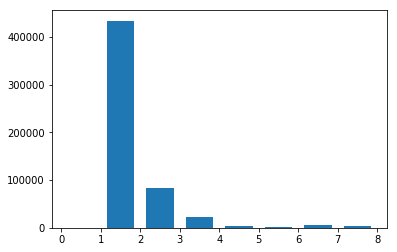

In [8]:
plt.hist(Y, bins=np.arange(len(np.unique(Y))+2), rwidth=.7, align='mid')

In [9]:
np.unique(Y)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.])

#### Plot a histogram of stages

(array([  42954.,   24250.,   30095.,   76401.,  322035.,   10290.,
           2103.,     952.,    2786.,   41326.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

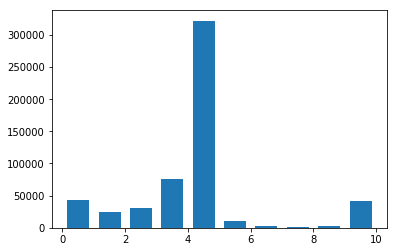

In [10]:
plt.hist(Y2, bins=np.arange(len(np.unique(Y2))+1), rwidth=.7, align='mid')

In [4]:
np.unique(Y2)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

# One hot encoding of dependent variables

In [5]:
offset = 1
num_classes = len(np.unique(Y))
Y_encoded=to_categorical(Y-offset, num_classes=num_classes)
Y_encoded.shape

(553192, 7)

In [6]:
offset = 0
num_classes = len(np.unique(Y2))
Y2_encoded=to_categorical(Y2, num_classes=num_classes)
Y2_encoded.shape

(553192, 10)

# Split the data to train, validation and test

* train = 60%
* validation = 20%
* test = 20%

In [7]:
x_train, x_validate, x_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
y_train, y_validate, y_test = np.split(Y_encoded, [int(.6*len(Y_encoded)), int(.8*len(Y_encoded))])
y2_train, y2_validate, y2_test = np.split(Y2_encoded, [int(.6*len(Y2_encoded)), int(.8*len(Y2_encoded))])

print (x_train.shape, y_train.shape, y2_train.shape)
print (x_validate.shape, y_validate.shape, y2_validate.shape)
print (x_test.shape, y_test.shape, y2_test.shape)

((331915, 32, 8), (331915, 7), (331915, 10))
((110638, 32, 8), (110638, 7), (110638, 10))
((110639, 32, 8), (110639, 7), (110639, 10))


### Histogram of classes in training data

(array([ 259741.,   47704.,   13477.,    2275.,    1808.,    4118.,    2792.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

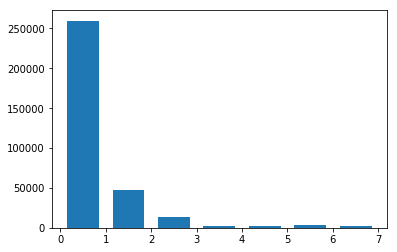

In [15]:
labels=np.argmax(y_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

(array([  25840.,   15718.,   18270.,   43892.,  193170.,    6269.,
           1670.,     605.,    1739.,   24742.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

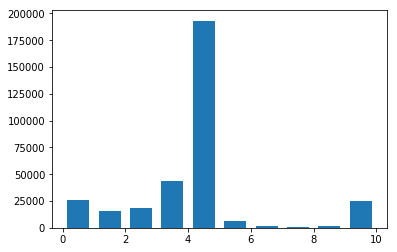

In [44]:
labels=np.argmax(y2_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

# Train a type classification model with LSTM

In [14]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 7
batch_size = 64
num_classes = y_train.shape[1]

layers = [LSTM(64, return_sequences=True, dropout=0.2,
               input_shape=(timesteps, data_dim)), 
         LSTM(64, return_sequences=True),
         LSTM(64),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# checkpoint
filepath="models/type_lstm_v4.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=num_epochs,
                    validation_data=(x_validate, y_validate),
                    callbacks=callbacks_list)

Train on 331915 samples, validate on 110638 samples
Epoch 1/7
331915/331915 [==============================] - 388s 1ms/step - loss: 0.3952 - acc: 0.8741 - val_loss: 0.3359 - val_acc: 0.9153
Epoch 2/7
331915/331915 [==============================] - 382s 1ms/step - loss: 0.2984 - acc: 0.9088 - val_loss: 0.3892 - val_acc: 0.8923
Epoch 3/7
331915/331915 [==============================] - 387s 1ms/step - loss: 0.2624 - acc: 0.9198 - val_loss: 0.3561 - val_acc: 0.9064
Epoch 4/7
331915/331915 [==============================] - 385s 1ms/step - loss: 0.2411 - acc: 0.9264 - val_loss: 0.3810 - val_acc: 0.9057
Epoch 5/7
331915/331915 [==============================] - 395s 1ms/step - loss: 0.2273 - acc: 0.9310 - val_loss: 0.3540 - val_acc: 0.9205
Epoch 6/7
331915/331915 [==============================] - 388s 1ms/step - loss: 0.2205 - acc: 0.9334 - val_loss: 0.3157 - val_acc: 0.9211
Epoch 7/7
331915/331915 [==============================] - 387s 1ms/step - loss: 0.2120 - acc: 0.9358 - val_loss: 

## View training history

In [16]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

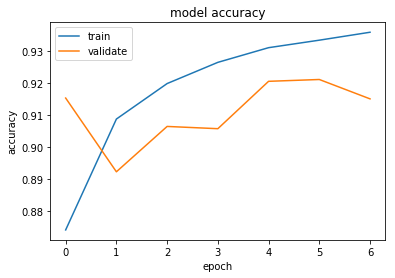

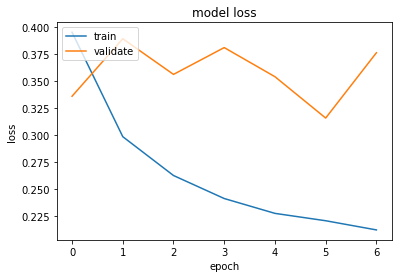

In [17]:
plot_history(history)

## Save the model
include the model and its weights

In [18]:
def save_model(model, model_filename="models/type_lstm_v2.json", weights_file_name=None):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_filename, "w") as json_file:
        json_file.write(model_json)
    print("Saved the model to disk")    
    
    # serialize weights to HDF5
    if weights_file_name is not None:
        model.save_weights(weights_file_name)
        print("Saved the model weights to disk")

In [20]:
save_model(model, "models/type_lstm_v4.json")

Saved the model to disk


## Use the saved model to predict on new data

In [21]:
def load_model(model_filename='models/type_lstm_v2.json', weights_filename="models/type_lstm_v2.h5"):
    # load json and create model
    json_file = open(model_filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_filename)
    print("Loaded the model from disk")
    
    return loaded_model

In [23]:
model = load_model('models/type_lstm_v4.json', "models/type_lstm_v4.h5")

Loaded the model from disk


## We need to compile the model before use it

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [25]:
model.metrics_names

['loss', 'acc']

In [26]:
score = model.evaluate(x_test, y_test, batch_size=64)

110639/110639 [==============================] - 31s 282us/step


In [27]:
score

[0.38147048888775953, 0.89647411852963244]

## Predict

**Remember** The classes are 0 to 6 instead of 1 to 7.

In [28]:
%%time
y_hat = model.predict(x_test)

CPU times: user 1min 1s, sys: 1.06 s, total: 1min 2s
Wall time: 58.1 s


In [29]:
x_test.shape

(110639, 32, 8)

### Prediction results are the probability of each class

In [30]:
y_hat.shape

(110639, 7)

In [31]:
y_hat

array([[  1.19457826e-01,   8.77557039e-01,   1.55393814e-03, ...,
          1.50985898e-05,   1.27468852e-03,   9.81507619e-05],
       [  1.21533349e-01,   8.75213206e-01,   1.64178142e-03, ...,
          1.20239192e-05,   1.46351394e-03,   9.42876213e-05],
       [  4.75936085e-02,   9.50170100e-01,   1.16700714e-03, ...,
          3.99459495e-05,   9.02160129e-04,   1.03273145e-04],
       ..., 
       [  9.90625381e-01,   5.08881640e-04,   1.47048943e-03, ...,
          3.75927343e-08,   2.66320494e-05,   3.51313502e-05],
       [  9.90583301e-01,   5.04449941e-04,   1.46508974e-03, ...,
          3.75639040e-08,   2.65817944e-05,   3.51804847e-05],
       [  9.90534723e-01,   5.01425646e-04,   1.46006839e-03, ...,
          3.77873377e-08,   2.66333718e-05,   3.53126015e-05]], dtype=float32)

# Train a stage classification model with LSTM

In [32]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 10
batch_size = 64
num_classes = y2_train.shape[1]

layers = [LSTM(batch_size, return_sequences=True, dropout=0.2,
               input_shape=(timesteps, data_dim)), 
         LSTM(batch_size, return_sequences=True),
         LSTM(batch_size),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# checkpoint
filepath="models/stage_lstm_v4.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y2_train,
                    batch_size=batch_size, epochs=num_epochs,
                    validation_data=(x_validate, y2_validate),
                    callbacks=callbacks_list)

Train on 331915 samples, validate on 110638 samples
Epoch 1/10
331915/331915 [==============================] - 390s 1ms/step - loss: 0.4441 - acc: 0.8596 - val_loss: 0.3109 - val_acc: 0.9175
Epoch 2/10
331915/331915 [==============================] - 388s 1ms/step - loss: 0.2608 - acc: 0.9167 - val_loss: 0.2770 - val_acc: 0.9233
Epoch 3/10
331915/331915 [==============================] - 388s 1ms/step - loss: 0.2055 - acc: 0.9329 - val_loss: 0.2604 - val_acc: 0.9155
Epoch 4/10
331915/331915 [==============================] - 387s 1ms/step - loss: 0.1747 - acc: 0.9423 - val_loss: 0.2847 - val_acc: 0.9150
Epoch 5/10
331915/331915 [==============================] - 387s 1ms/step - loss: 0.1562 - acc: 0.9482 - val_loss: 0.3193 - val_acc: 0.9103
Epoch 6/10
331915/331915 [==============================] - 387s 1ms/step - loss: 0.1429 - acc: 0.9531 - val_loss: 0.2792 - val_acc: 0.9253
Epoch 7/10
331915/331915 [==============================] - 387s 1ms/step - loss: 0.1343 - acc: 0.9557 - val

## View training history

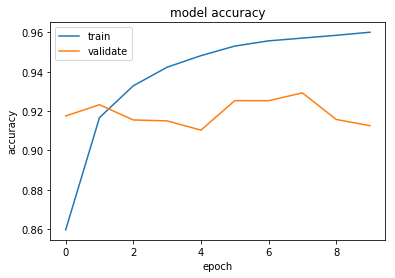

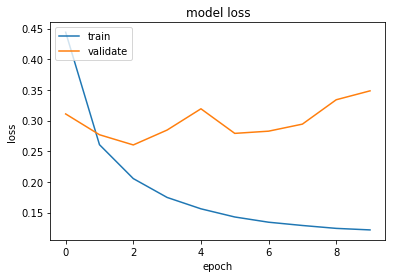

In [44]:
plot_history(history)

## Save the model
include the model and its weights

In [45]:
save_model(model, "models/stage_lstm_v4.json")

Saved the model to disk


## Use the saved model to predict on new data

In [46]:
model = load_model('models/stage_lstm_v4.json', "models/stage_lstm_v4.h5")

Loaded the model from disk


## We need to compile the model before use it

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [48]:
model.metrics_names

['loss', 'acc']

In [49]:
score = model.evaluate(x_test, y2_test, batch_size=64)

110639/110639 [==============================] - 32s 285us/step


In [50]:
score

[0.33510705966009391, 0.91835609505432314]

## Predict

In [51]:
%%time
y_hat = model.predict(x_test)

CPU times: user 1min, sys: 993 ms, total: 1min 1s
Wall time: 56.6 s


In [52]:
x_test.shape

(110639, 32, 8)

### Prediction results are the probability of each class

In [53]:
y_hat.shape

(110639, 10)

In [54]:
y_hat

array([[  2.03429852e-04,   7.06538267e-05,   5.46302763e-05, ...,
          6.49701235e-08,   5.21942929e-05,   1.80770585e-03],
       [  2.99424311e-04,   9.67617307e-05,   8.76517588e-05, ...,
          2.89129858e-08,   1.41460741e-05,   2.37101642e-03],
       [  1.97767193e-04,   9.27789879e-05,   5.56157938e-05, ...,
          1.54798386e-07,   9.70367400e-05,   2.69811554e-03],
       ..., 
       [  3.94886265e-05,   3.19437786e-05,   3.70179373e-06, ...,
          1.93347693e-09,   3.06657300e-09,   9.99889255e-01],
       [  3.84801060e-05,   3.24358080e-05,   3.76565822e-06, ...,
          1.89825133e-09,   3.06724579e-09,   9.99889255e-01],
       [  3.77324359e-05,   3.21942462e-05,   3.76529397e-06, ...,
          1.78756110e-09,   2.91652325e-09,   9.99889851e-01]], dtype=float32)